In [550]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define ETFs for expansion and contraction phases
etfs_expansion = ['XLK', 'XLY', 'XLI', 'XLF', 'XLE']
etfs_contraction = ['XLI', 'XLV', 'XLU', 'XLP']

# Step 2: Download ETF data from Yahoo Finance
all_etfs = etfs_expansion + etfs_contraction
etf_prices = yf.download(all_etfs, start='1990-03-01', end = '2020-04-30')['Adj Close']

# Make sure that you have a DataFrame, not a Series, and then select 'Adj Close'

# Step 3: Handle missing data by forward-filling prices
etf_prices = etf_prices.ffill()

# Display the first few rows of prices to check data
print(etf_prices.head())

[*********************100%%**********************]  8 of 8 completed

Ticker            XLE        XLF        XLI        XLK        XLP        XLU  \
Date                                                                           
1998-12-22  12.034075  11.425528  14.745354  24.064363  14.558569  12.181776   
1998-12-23  12.284616  11.594010  15.002661  24.639290  14.910522  12.130730   
1998-12-24  12.219967  11.670585  15.200577  24.545410  14.884760  12.354067   
1998-12-28  12.155310  11.517426  15.279752  24.615810  14.798923  12.290258   
1998-12-29  12.276537  11.639952  15.497472  24.686216  15.125118  12.494457   

Ticker            XLV        XLY  
Date                              
1998-12-22  17.233095  18.995117  
1998-12-23  17.620354  19.076689  
1998-12-24  17.727928  19.426298  
1998-12-28  17.469761  19.251507  
1998-12-29  17.857019  19.671011  


In [551]:
# Step 4: Define the economic phases
expansion_periods = [('1998-12-22', '2001-03-01'),
                     ('2001-11-01', '2007-12-01'),
                     ('2009-06-01', '2020-02-01'),
                     ('2020-04-01','2024-01-01')]

contraction_periods = [
                       ('2001-03-01', '2001-11-01'),
                       ('2007-12-01', '2009-06-01'),
                       ('2020-02-01', '2020-04-01')]

#the dates that have 0 or even index are contraction dates, the dates that have odd index are expansion
start_dates = ['1998-12-22','2001-03-01','2001-11-01','2007-12-01','2009-06-01','2020-02-01','2020-04-01']
end_dates = ['2001-03-01','2001-11-01','2007-12-01','2009-06-01','2020-02-01','2020-04-01','2024-01-01']
#the method in which we will access the contraction dates will be using the 0 or even index and expansion using the odd index

In [552]:
#here we are defining the initial investnment amount that we are starting off with for backtesting
global amount_to_invest
global values_of_portfolio
amount_to_invest = 100000
values_of_portfolio = pd.Series()
# Step 5: Function to invest in ETFs during a period
#loop from 0 to the length of dates to invest and if statements to determine if it is a contraction or expansion
def invest(start_date, end_date, period_etfs, etf_prices, amount_to_invest,values_of_portfolio):

    #get the prices for the respective etfs for the period we are investing in
    first_day_period_prices = etf_prices[(etf_prices.index >= start_date) & (etf_prices.index <= end_date)][period_etfs]

    # Invest equally in the given ETFs
    amount_per_etf = amount_to_invest / len(period_etfs)
    #get the number of shares we will be investing in for each etf
    num_shares = amount_per_etf / first_day_period_prices.iloc[0]

    #multiply the intial number of shares bought with the daily price of the respective etfs
    worth = num_shares * first_day_period_prices

    #value of the shares column
    worth['value'] = worth.apply(np.sum, axis=1)
    
    values_of_portfolio=pd.concat([pd.Series(values_of_portfolio), pd.Series(worth['value'])])

    #update the amount to invest to the value of the portfolio
    amount_to_invest = worth.iloc[-1,-1]
    
    #return the latest amount of the portfolio
    return (amount_to_invest,values_of_portfolio)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Final portfolio value on 2024-01-01: $564,864.92


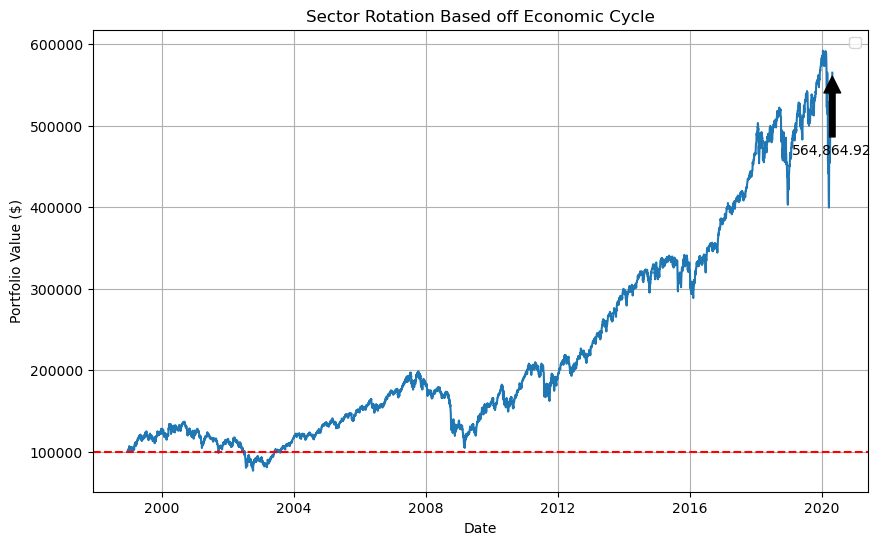

In [553]:
for i in range(len(start_dates)):
    
    if i == 0 or i%2==0:
        #take the value that is held in current holdings and invest in expansionary etfs
        result = invest(start_dates[i],end_dates[i],etfs_expansion,etf_prices,amount_to_invest,values_of_portfolio)
        
        amount_to_invest = result[0]
    
        values_of_portfolio = result[1]
    elif i%2==1:
        #take the value that is held in current holdings and invest in contractionary etfs
        #here depending on the if, we will input the contraction etfs and use the contraction etf_prices
        result = invest(start_dates[i],end_dates[i],etfs_contraction,etf_prices,amount_to_invest,values_of_portfolio)
        amount_to_invest = result[0]
        values_of_portfolio = result[1]
        

final_portfolio_value = amount_to_invest
print(f"Final portfolio value on 2024-01-01: ${values_of_portfolio[-1]:,.2f}")
plt.figure(figsize=(10,6))
plt.plot(values_of_portfolio, label='')
plt.title('Sector Rotation Based off Economic Cycle')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
# Get the last data point
last_date = values_of_portfolio.index[-1]
last_value = values_of_portfolio.iloc[-1]

# Annotate the last point
plt.annotate(f'{last_value:,.2f}',  # Text to display
             xy=(last_date, last_value),  # Coordinates of the point
             xytext=(last_date, last_value - 100000),  # Position of the text
             arrowprops=dict(facecolor='black', shrink=0.05),  # Arrow properties
             fontsize=10,  # Font size
             color='black',  # Text color
             horizontalalignment='center',  # Text alignment
             )
plt.grid(True)
plt.axhline(y=100000, color='red', linestyle='--', label='Initial Investment')

plt.show()

plt.show()

In [554]:
#Lets develop some functions for portfolio metrics we will use
def sharpe_ratio(returns, risk_free_rate):
    # Convert risk-free rate to daily rate
    daily_risk_free_rate = (1 + risk_free_rate)**(1/252) - 1    
    # Excess returns
    excess_returns = returns - daily_risk_free_rate
    # Annualized return and volatility
    annualized_return = np.mean(returns) * 252
    annualized_volatility = np.std(returns) * np.sqrt(252)
    # Sharpe Ratio
    sharpe_ratio_value = (annualized_return - risk_free_rate) / annualized_volatility
    return sharpe_ratio_value

    
def volatility(portfolio_returns):
    annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)
    return annualized_volatility

def max_drawdown(portfolio_returns):
     # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    # Calculate the running maximum of cumulative returns
    rolling_max = cumulative_returns.cummax()
    # Calculate the drawdown
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    # Maximum drawdown
    max_drawdown_value = drawdown.min()
    return max_drawdown_value

def calculate_var(portfolio_returns, confidence_level=0.05):
    # Calculate the z-score for the given confidence level
    z_score = np.abs(np.percentile(portfolio_returns, (1 - confidence_level) * 100))
    # Mean and standard deviation of returns
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    # Value at Risk (VaR)
    VaR = mean_return - z_score * std_dev
    return VaR

Now let's compare the performance between our active sector rotation strategy versus the S&P500

[*********************100%%**********************]  1 of 1 completed


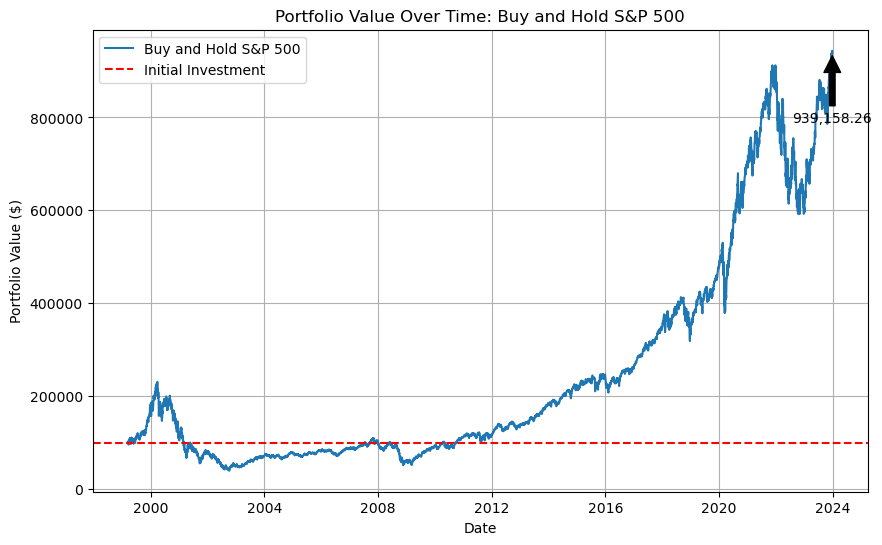

Final portfolio value on 2024-01-01: $939,158.26


In [563]:
# Initial investment
initial_investment = 100000  # $100,000

# Download S&P 500 price data (using SPY ETF as proxy for S&P 500 index)
sp500 = yf.download('QQQ', start='1998-12-22', end='2024-01-01')

# Use the 'Adj Close' column to represent the adjusted closing price
sp500_prices = sp500['Adj Close']

# Calculate daily returns (percentage change)
sp500_returns = sp500_prices.pct_change()

# Calculate the cumulative returns for the buy-and-hold strategy
cumulative_returns = (1 + sp500_returns).cumprod()

# Calculate the value of the portfolio over time
sp_portfolio_value = cumulative_returns * initial_investment

# Drop any NaN values (e.g., from the first row since we used pct_change)
sp_portfolio_value = sp_portfolio_value.dropna()

# Plot the portfolio value over time
plt.figure(figsize=(10,6))
plt.plot(sp_portfolio_value, label='Buy and Hold S&P 500')
plt.title('Portfolio Value Over Time: Buy and Hold S&P 500')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
last_date = sp_portfolio_value.index[-1]
last_value = sp_portfolio_value.iloc[-1]

# Annotate the last point
plt.annotate(f'{last_value:,.2f}',  # Text to display
             xy=(last_date, last_value),  # Coordinates of the point
             xytext=(last_date, last_value - 150000),  # Position of the text
             arrowprops=dict(facecolor='black', shrink=0.05),  # Arrow properties
             fontsize=10,  # Font size
             color='black',  # Text color
             horizontalalignment='center',  # Text alignment
             )
plt.axhline(y=100000, color='red', linestyle='--', label='Initial Investment')
plt.legend()
plt.grid(True)
plt.show()

# Output the final portfolio value at the end date
print(f"Final portfolio value on 2024-01-01: ${sp_portfolio_value[-1]:,.2f}")


Let's determine some metrics to evaluate the performance of our sector rotation strategy

In [558]:

def sharpe_ratio(daily_returns):
    risk_free_rate = 0.01 / 252  # Adjusting annual risk-free rate to daily
    mean_daily_return = daily_returns.mean()
    std_dev = daily_returns.std()
    return (mean_daily_return - risk_free_rate) / std_dev


def value_at_risk(daily_returns):
    confidence_level = 0.05  # 5% VaR
    return np.percentile(daily_returns, 100 * confidence_level)


def max_draw_down(daily_returns):
    rolling_max = daily_returns.cummax()
    drawdown = (daily_returns - rolling_max) / rolling_max
    return drawdown.min()


def volatility(daily_returns):
    std_dev = daily_returns.std()
    return std_dev * np.sqrt(252)  # Annualized volatility

def total_returns(values_of_portfolio):
    beginning_value = values_of_portfolio.iloc[0]  # First value in the series
    ending_value = values_of_portfolio.iloc[-1]
    return ((ending_value - beginning_value) / beginning_value) * 100

In [559]:
daily_returns_sector_rot = values_of_portfolio.pct_change().dropna()

# Output the results for sector rotation
print('sharpe ratio (sector rotation): ', sharpe_ratio(daily_returns_sector_rot))
print('value at risk (sector rotation): ', value_at_risk(daily_returns_sector_rot))
print('maximum drawdown (sector rotation): ', max_drawdown(daily_returns_sector_rot))
print('annualised volatility (sector rotation): ', volatility(daily_returns_sector_rot))
print('total returns (sector rotation) % ', total_returns(values_of_portfolio))

sharpe ratio (sector rotation):  0.029425889416198208
value at risk (sector rotation):  -0.019278034210759198
maximum drawdown (sector rotation):  -0.47305890770073294
annualised volatility (sector rotation):  0.19178819155279175
total returns (sector rotation) %  464.8649211331481


In [561]:
daily_returns_sp = sp_portfolio_value.pct_change().dropna()

print('sharpe ratio s&p500: ', sharpe_ratio(daily_returns_sp))
print('value at risk s&p500: ', value_at_risk(daily_returns_sp))
print('maximum drawdown s&p500: ', max_drawdown(daily_returns_sp))
print('annualised volatility s&p500: ', volatility(daily_returns_sp))
print('total returns s&p500 % ', total_returns(sp_portfolio_value))

sharpe ratio s&p500:  0.026137039008348045
value at risk s&p500:  -0.019235100064833702
maximum drawdown s&p500:  -0.5518942310538623
annualised volatility s&p500:  0.19559422535637835
total returns s&p500 %  504.0067640947103


[*********************100%%**********************]  3 of 3 completed


881931.9942690822


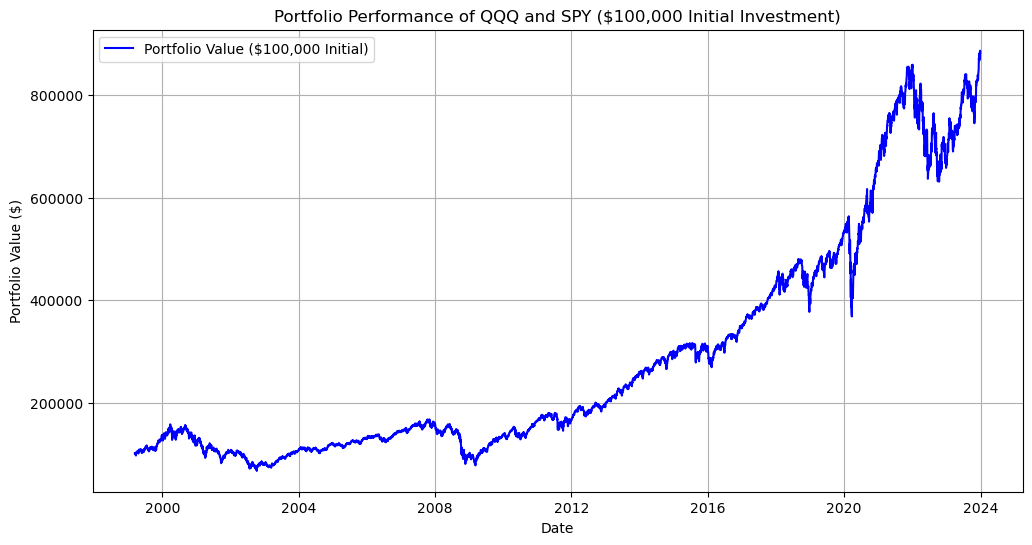

In [574]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download Historical Data
etfs = ['SPY', 'QQQ','MDY']
start_date = '1998-12-22'
end_date = '2024-01-01'

# Fetch the data
etf_prices = yf.download(etfs, start=start_date, end=end_date)['Adj Close']

# Step 2: Calculate Daily Returns
etf_returns = etf_prices.pct_change().dropna()

# Step 3: Portfolio Allocation (Equal weights)
weights = np.array([0.33, 0.33,0.34])  # 50% in SPY and 50% in QQQ
portfolio_returns = (etf_returns * weights).sum(axis=1)

# Step 4: Calculate Cumulative Returns and Portfolio Value
initial_investment = 100000
cumulative_returns = (1 + portfolio_returns).cumprod() * initial_investment
print(cumulative_returns[-1])
# Step 5: Plot the Portfolio Performance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Portfolio Value ($100,000 Initial)', color='blue')
plt.title('Portfolio Performance of QQQ and SPY ($100,000 Initial Investment)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid()
plt.show()


In [576]:
daily_returns = cumulative_returns.pct_change().dropna()

print('sharpe ratio s&p500: ', sharpe_ratio(daily_returns))
print('value at risk s&p500: ', value_at_risk(daily_returns))
print('maximum drawdown s&p500: ', max_drawdown(daily_returns))
print('annualised volatility s&p500: ', volatility(daily_returns))
print('total returns s&p500 % ', total_returns(cumulative_returns))

sharpe ratio s&p500:  0.029287117649048396
value at risk s&p500:  -0.022080718230869694
maximum drawdown s&p500:  -0.5756041036161722
annualised volatility s&p500:  0.218380709194015
total returns s&p500 %  776.8059171779549
